# Experiments Tracking in Azure ML

This notebook shows how to track experiments and store the artifacts using Azure's native mechanism (in `Azure Machine Learning Python SDK v1`).

The logging scope is quite extensive: 
* experiment metadata (including tags and long description)
* source code version (git commit)
* displayable tables and figures
* arbitrary files (no interactive view) 

## Preliminaries

We will need `scikit-learn` for model training, `matplotlib` for plotting and - of course - `azureml` for experiment tracking:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from azureml.core import Workspace, Experiment

plt.rc("savefig", transparent=True)

Connect to the default Azure workspace, start (or reconnect) an experiment, and start a tracking run:

In [2]:
# use the default Azure workspace
ws = Workspace.from_config()
exp = Experiment(ws, 'digits_recognition')
tags = {'project':'Experiment Tracking in Azure','type':'tutorial'}
description = 'Tutorial on Tracking Jobs in Azure. Trains a sklearn classifier on the "digits" dataset and registers outcomes.'
run = exp.start_logging(snapshot_directory=None,tags=tags,description=description)

## Train and Track Artifacts

### Sample Input Images

Let's have a look at some input images - and log them:

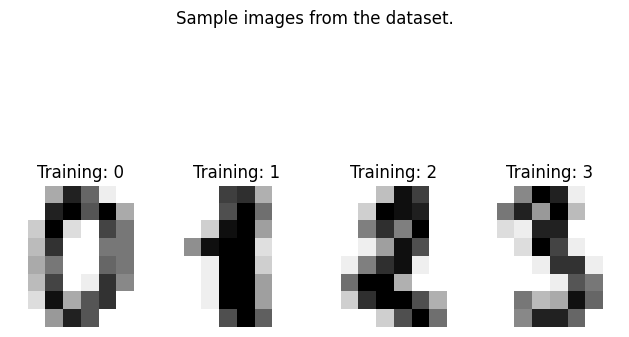

In [3]:
digits = datasets.load_digits()

fig, axes = plt.subplots(nrows=1, ncols=4, constrained_layout=True)
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)
fig.suptitle('Sample images from the dataset.')
plt.tight_layout()
run.log_image('digits_sample_images',plot=fig)

### Train Classifier

Choose an SVC model, as a generally good classifier for high-dimensional data:

In [4]:
# choose an SVC momdel
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
clf = svm.SVC(gamma=0.001)
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.3, shuffle=True
)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

### Validate Model

Let's create the classification report, display and log to Azure. 
Note that we have to log a table as a dictionary in `column -> [values]}` format:

In [5]:
df_report = metrics.classification_report(y_test, predicted,output_dict=True)
df_report = pd.DataFrame(df_report)
df_report.rename({f'{i}':f'label={i}' for i in range(10)},axis=1,inplace=True)
df_report = df_report.T
df_report.index.name = 'target'
df_report

,precision,recall,f1-score,support
target,,,,
label=0,1.000000,1.000000,1.000000,48.000000
label=1,0.984375,1.000000,0.992126,63.000000
label=2,1.000000,1.000000,1.000000,63.000000
label=3,0.983333,1.000000,0.991597,59.000000
label=4,1.000000,1.000000,1.000000,47.000000
label=5,0.982456,0.982456,0.982456,57.000000
label=6,1.000000,0.982759,0.991304,58.000000
label=7,1.000000,1.000000,1.000000,52.000000
label=8,1.000000,1.000000,1.000000,46.000000


In [6]:
run.log_table('classification_report',df_report.reset_index().to_dict(orient='list'))

Finally, let's display the confusion matrix and log to Azure:

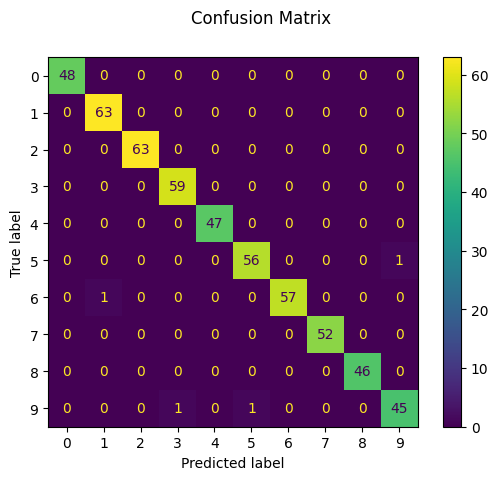

In [7]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
fig = disp.figure_
fig.suptitle("Confusion Matrix")
run.log_image('confusion_matrix',plot=fig)

Finally, remember to complete the experiment run:

In [8]:
run.complete()

## Retrieve Artifacts

You can access all the details with the Python API, but may be simpler to just view them in Azure Studio.

```{warning}
In case of access issues, check firewall rules of the artifacts datastore (here: workspaceartifactstore)
```

### Experiment Overview in Azure Studio

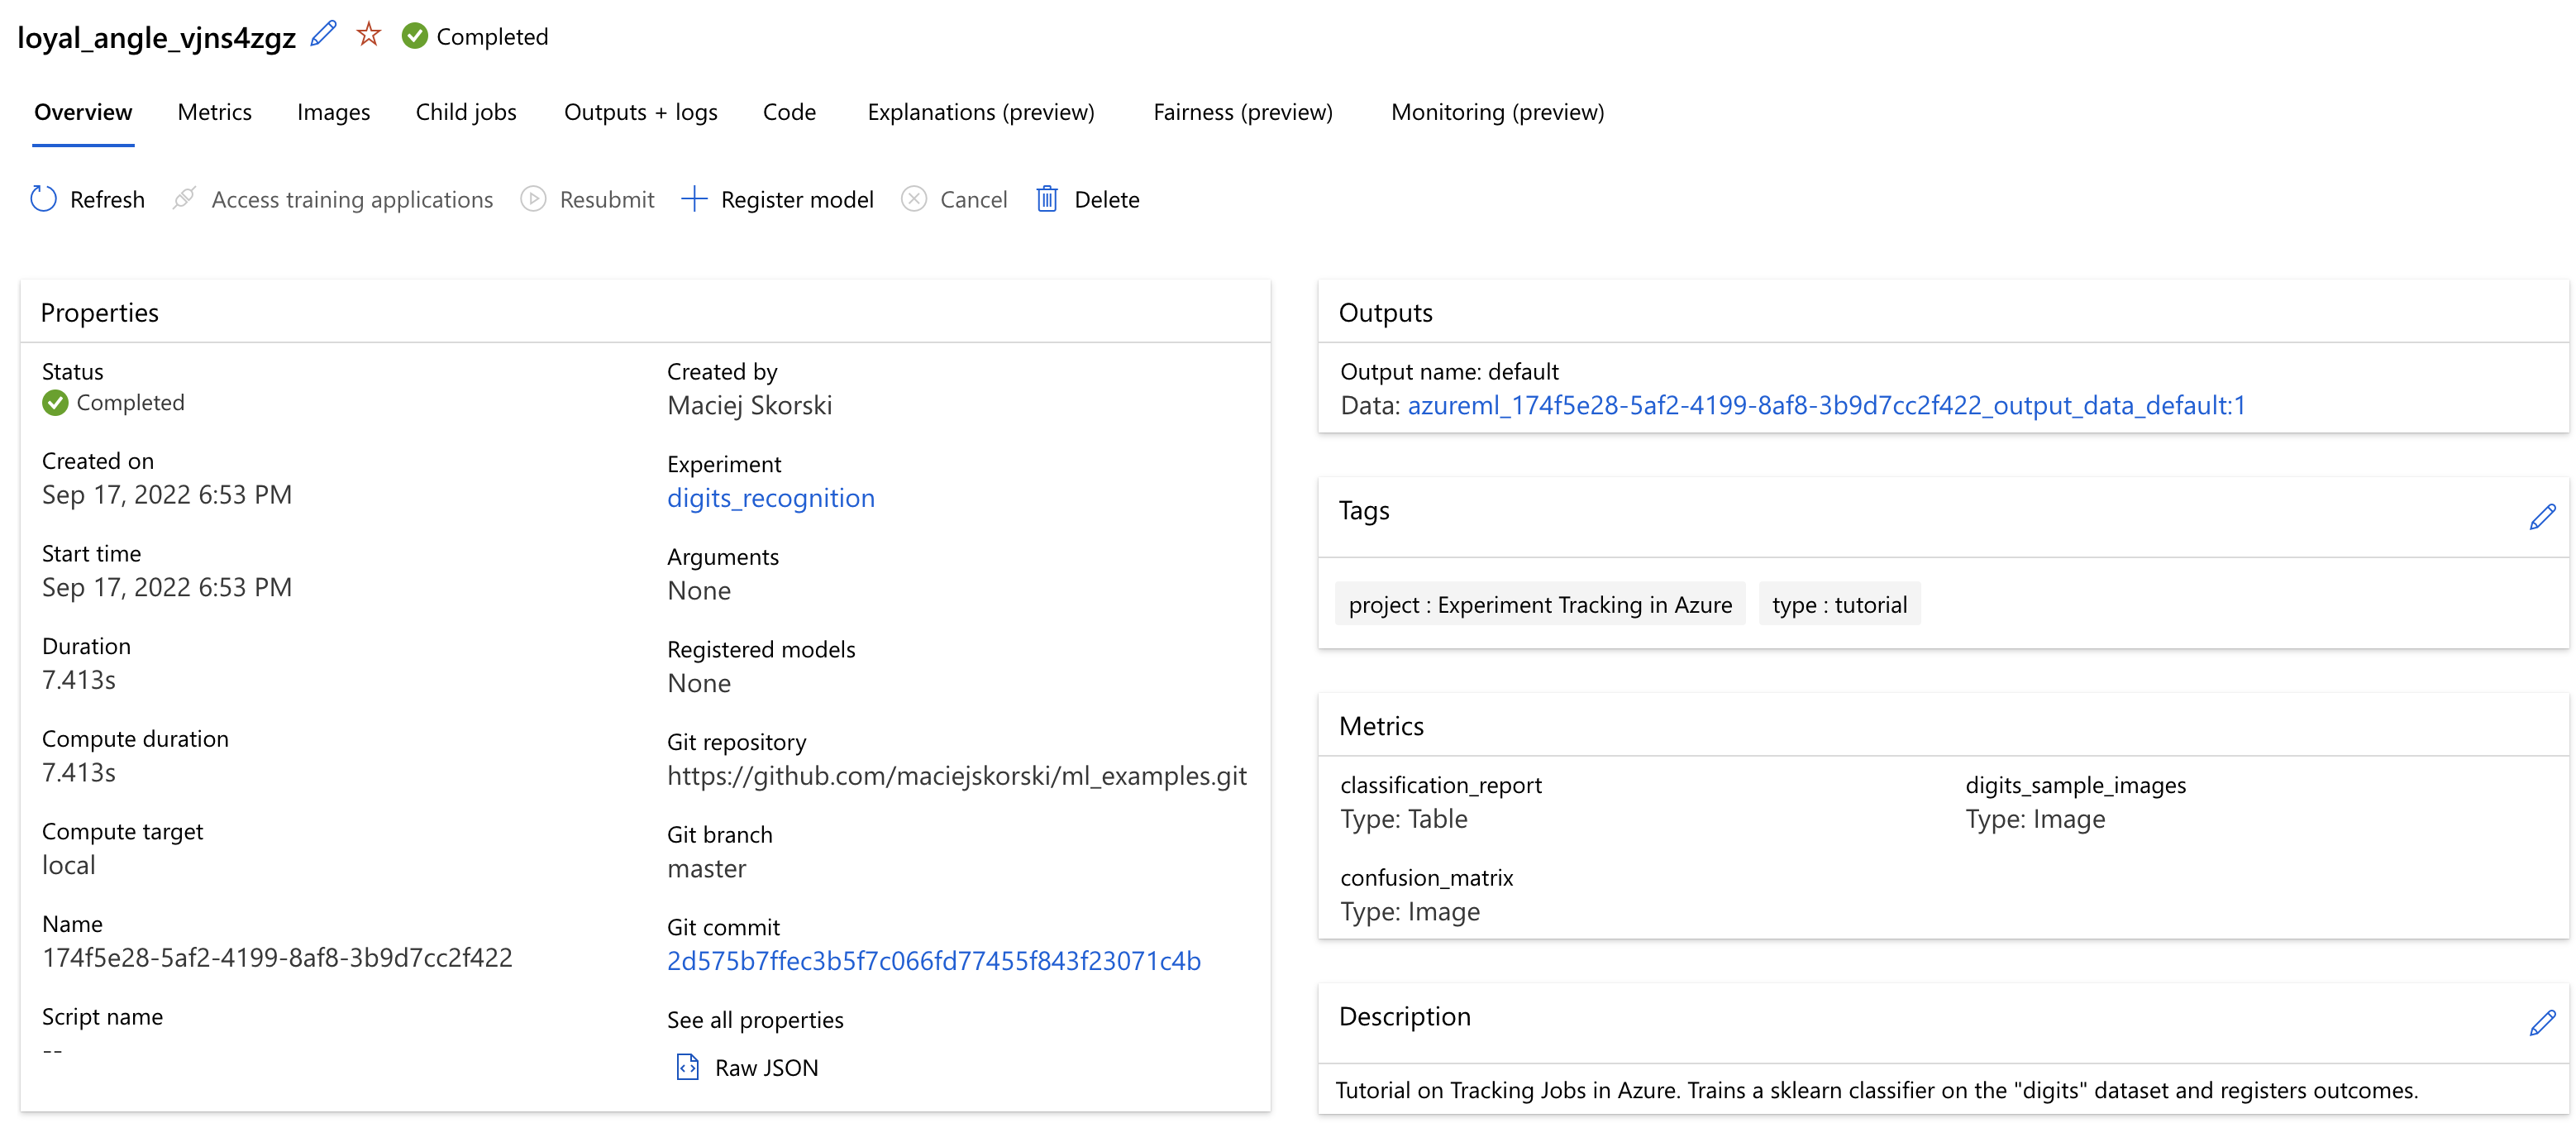

In [1]:
#from IPython.display import Image
#Image("/home/azureuser/ml_examples/docs/azure_experiments_view.png")

### Run Details in Azure Studio

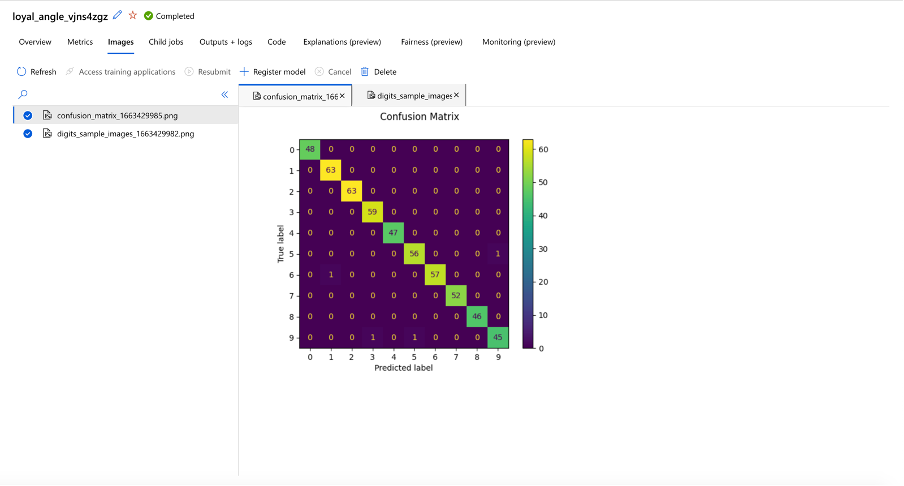

In [3]:
from IPython.display import Image
Image("/home/azureuser/ml_examples/docs/azure_experiments_artifacts.png")